In [2]:
import os
# import drjit
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sionna
import tensorflow as tf
import pickle
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
tf.get_logger().setLevel('ERROR')
tf.config.run_functions_eagerly(True)

from jammer.simulation_model import *
from jammer.utils import *
import jammer.simulation_model as sim
from tensorflow.python.keras.losses import MeanAbsoluteError, MeanSquaredError, BinaryCrossentropy

## Weight Grid

This is the training code and display code for the unmitigated weight grid

In [2]:
# model_parameters = {}
# jammer_parameters = {}
# model_parameters["perfect_csi"] = False
# model_parameters["jammer_present"] = True
# model_parameters["num_silent_pilot_symbols"] = 0
# jammer_parameters["trainable"] = True
# model_parameters["jammer_parameters"] = jammer_parameters
# jammer_parameters["trainable_mask"] = tf.ones([14, 1], dtype=tf.bool)
# 
# sim.BATCH_SIZE = 2
# 
# # massive grid: training with different jammer power and different number of UEs
# num_ut = range(1, 9)
# jammer_power = [db_to_linear(x) for x in np.arange(-2.5, 15.1, 2.5, dtype=np.float32)]
# parameters = [(x, y) for x in num_ut for y in jammer_power]
# n, p = parameters[parameter_num]
# model_parameters["num_ut"] = n
# model_parameters["jammer_power"] = p
# model_parameters["num_ofdm_symbols"] = 14
# model_parameters["fft_size"] = 64
# model_parameters["num_bs_ant"] = 24
# jammer_parameters["trainable_mask"] = tf.ones([14, 1], dtype=tf.bool)
# model = Model(**model_parameters)
# train_model(model,
#             loss_fn=negative_function(MeanAbsoluteError()),
#             loss_over_logits=False,
#             weights_filename=f"weights/unmitigated/grid/ue_{n}_power_{linear_to_db(p):.1f}dB.pickle",
#             log_tensorboard=True,
#             log_weight_images=True,
#             show_final_weights=False,
#             num_iterations=2000,
#             ebno_db=2.5)

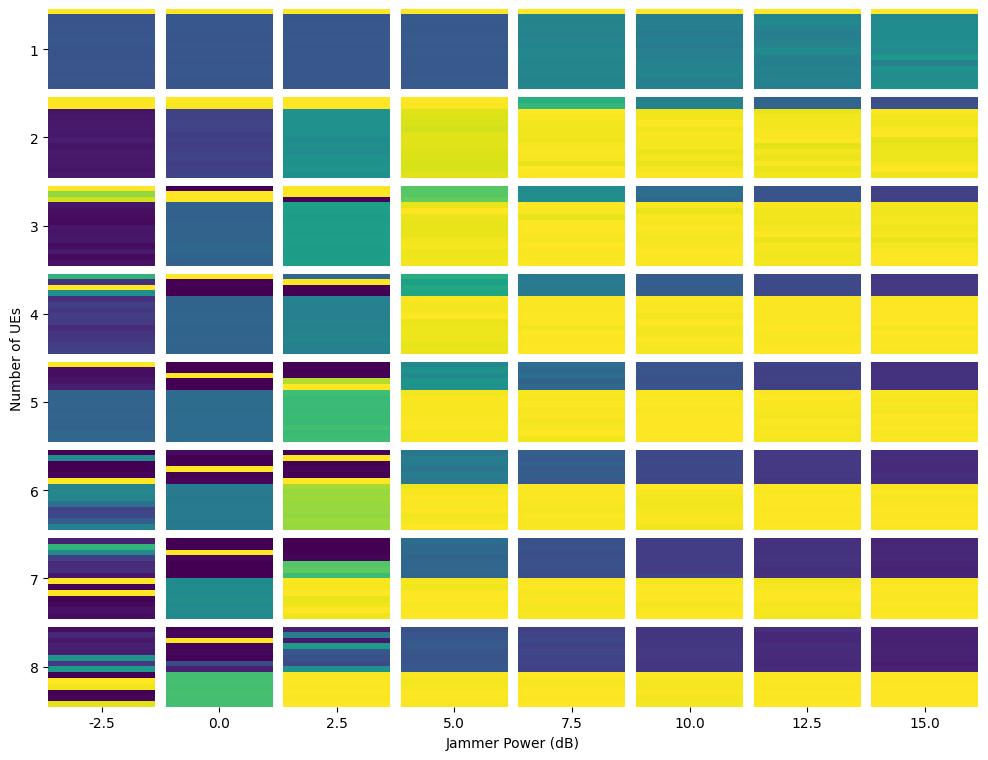

In [3]:
plt.figure(figsize=(10, 7.5))
num_ut = range(1, 9)
jammer_power = np.arange(-2.5, 15.1, 2.5, dtype=np.float32)
bers = np.zeros([len(num_ut), len(jammer_power)])
for i in range(len(num_ut)):
    for j in range(len(jammer_power)):
        n = num_ut[i]
        p = jammer_power[j]
        filename = f"weights/unmitigated/grid/ue_{n}_power_{p}dB.pickle"
        with open(filename, 'rb') as f:
            weights = pickle.load(f)[1]
        weights = NonNegMaxMeanSquareNorm()(weights)
        plt.subplot(len(num_ut), len(jammer_power), i * len(jammer_power) + j + 1)
        plt.axis('off')
        # plt.imshow(weights, aspect='auto')
        plt.imshow(weights, aspect='auto', vmin=0)

# parameters: space between plots
wspace = 0.1
hspace = 0.1
m = len(num_ut)
n = len(jammer_power)
plt.subplots_adjust(bottom=0.07, top=1.0, left=0.07, right=1.0, wspace=wspace, hspace=hspace)
# labels on the x and y plots-axis
ax = plt.gcf().add_axes([0.07, 0.07, 0.93, 0.93], frameon=False)
plot_width = 1.0 / (n + (n - 1) * wspace)
gap_width = wspace * plot_width
ax.set_xticks(np.arange(plot_width / 2, 1.0, gap_width + plot_width), labels=jammer_power)
ax.set_xlabel("Jammer Power (dB)")
ax.invert_yaxis()
plot_height = 1.0 / (m + (m - 1) * hspace)
gap_height = hspace * plot_height
ax.set_yticks(plot_height / 2 + np.arange(m) * (gap_height + plot_height), labels=num_ut)
ax.set_ylabel("Number of UEs")

plt.show()

## Simple Jammer Result

First demonstration: Unjammed vs Jammed(unmitigated) vs Jammed(POS)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 4.0253e-02 | 1.0000e+00 |    11871126 |   294912000 |       128000 |      128000 |       190.2 |reached max iter       
     -4.0 | 2.0660e-02 | 1.0000e+00 |     6092876 |   294912000 |       128000 |      128000 |       189.3 |reached max iter       
     -3.0 | 9.2751e-03 | 1.0000e+00 |     2735349 |   294912000 |       128000 |      128000 |       190.1 |reached max iter       
     -2.0 | 3.6385e-03 | 9.8172e-01 |     1073042 |   294912000 |       125660 |      128000 |       189.6 |reached max iter       
     -1.0 | 1.3008e-03 | 6.9276e-01 |      383618 |   294912000 |        88673 |      128000 |       189.4 |reached max iter       
      0.0 | 4.5734e-04 | 3.0153e-01 |      134875 |   294912000 |        38596 |     

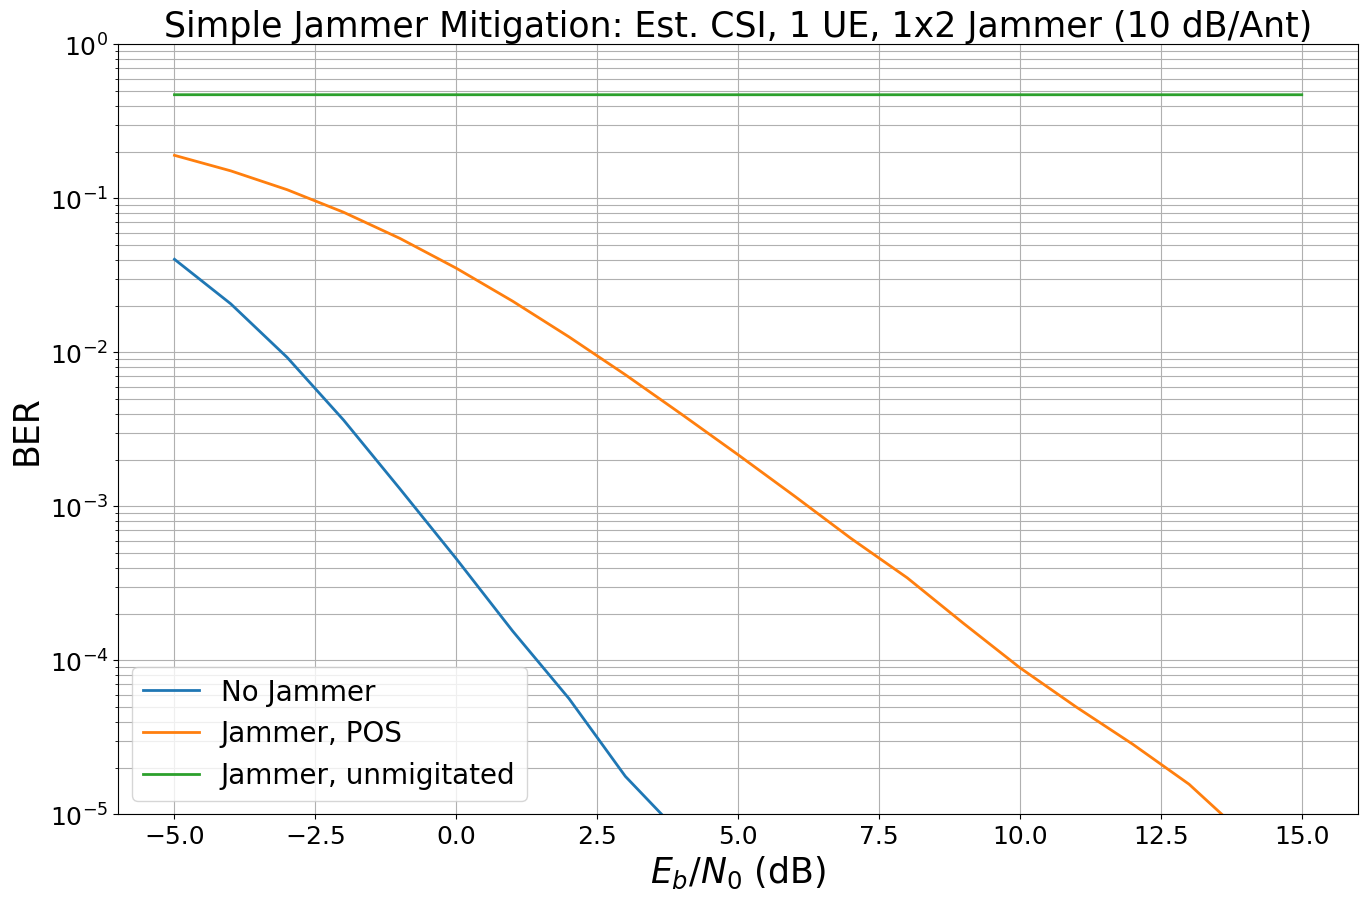

In [4]:
ber_plots.reset()
model_parameters = {}
jammer_parameters = {}
model_parameters["num_ut"] = 1
model_parameters["perfect_csi"] = False
model_parameters["num_silent_pilot_symbols"] = 4
jammer_parameters["num_tx_ant"] = 2
model_parameters["jammer_parameters"] = jammer_parameters
sim.BATCH_SIZE = 256
sim.MAX_MC_ITER = 500
# sim.ebno_dbs = np.linspace(-5., 15., 10)
sim.ebno_dbs = np.linspace(-5., 15., 21)

ber_plots.reset()
model = Model(**model_parameters)
simulate_model(model, "No Jammer")

model_parameters["perfect_jammer_csi"] = False
model_parameters["jammer_present"] = True
model_parameters["jammer_power"] = db_to_linear(10.)
model_parameters["jammer_mitigation"] = "pos"
model_parameters["jammer_mitigation_dimensionality"] = 2
model = Model(**model_parameters)
simulate_model(model, "Jammer, POS")

model_parameters["jammer_mitigation"] = None
model = Model(**model_parameters)
simulate_model(model, "Jammer, unmigitated")

ber_plots.title = "Simple Jammer Mitigation: Est. CSI, 1 UE, 1x2 Jammer (10 dB/Ant)"
ber_plots(ylim=(1e-5, 1))
with open("bers/simple_pos.pickle", 'wb') as f:
    bers = pickle.dump(ber_plots, f)

Now we add some velocity (0km/h, 20km/h, 120km/h). Compared with unmitigated jammer.

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 4.7141e-01 | 1.0000e+00 |   139024538 |   294912000 |       128000 |      128000 |       272.5 |reached max iter       
     -4.0 | 4.7145e-01 | 1.0000e+00 |   139035615 |   294912000 |       128000 |      128000 |       273.6 |reached max iter       
     -3.0 | 4.7139e-01 | 1.0000e+00 |   139018940 |   294912000 |       128000 |      128000 |       274.4 |reached max iter       
     -2.0 | 4.7133e-01 | 1.0000e+00 |   139002026 |   294912000 |       128000 |      128000 |       274.6 |reached max iter       
     -1.0 | 4.7131e-01 | 1.0000e+00 |   138994819 |   294912000 |       128000 |      128000 |       272.5 |reached max iter       
      0.0 | 4.7124e-01 | 1.0000e+00 |   138975380 |   294912000 |       128000 |     

FileNotFoundError: [Errno 2] No such file or directory: 'bers/simple_pos_mobility.pickle'

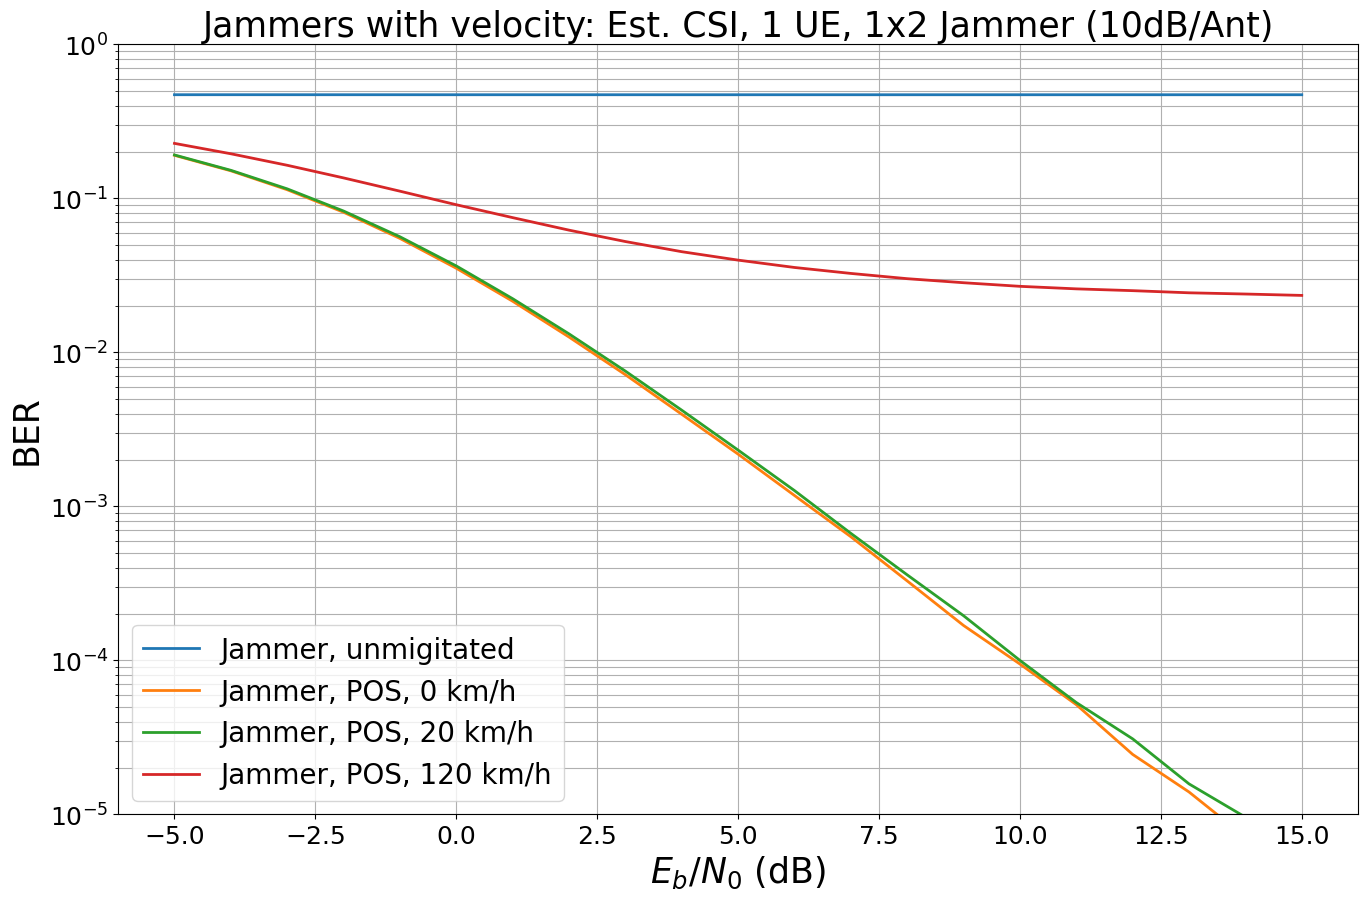

In [5]:
ber_plots.reset()
model_parameters = {}
jammer_parameters = {}
model_parameters["jammer_parameters"] = jammer_parameters
model_parameters["num_ut"] = 1
model_parameters["perfect_csi"] = False
model_parameters["perfect_jammer_csi"] = False
model_parameters["num_silent_pilot_symbols"] = 4
jammer_parameters["num_tx_ant"] = 2
model_parameters["jammer_present"] = True
model_parameters["jammer_power"] = db_to_linear(10.)
sim.BATCH_SIZE = 256
sim.MAX_MC_ITER = 500
sim.ebno_dbs = np.linspace(-5., 15., 21)

model = Model(**model_parameters)
simulate_model(model, "Jammer, unmigitated")

model_parameters["jammer_mitigation"] = "pos"
model_parameters["jammer_mitigation_dimensionality"] = 2
kmhs = [0, 20, 120]
for kmh in kmhs:
    meter_per_second = kmh / 3.6
    model_parameters["min_ut_velocity"] = meter_per_second
    model_parameters["max_ut_velocity"] = meter_per_second
    model_parameters["min_jammer_velocity"] = meter_per_second
    model_parameters["max_jammer_velocity"] = meter_per_second
    model = Model(**model_parameters)
    simulate_model(model, f"Jammer, POS, {kmh} km/h")

ber_plots.title = "Jammers with velocity: Est. CSI, 1 UE, 1x2 Jammer (10dB/Ant)"
ber_plots(ylim=(1e-5, 1))
with open("bers/simple_pos_mobility.pickle", 'wb') as f:
    bers = pickle.dump(ber_plots, f)

## Time Domain Simulation

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 2.2778e-03 | 1.0000e+00 |        4665 |     2048000 |          200 |         200 |         3.1 |reached max iter       
     -4.0 | 8.4033e-04 | 9.9500e-01 |        1721 |     2048000 |          199 |         200 |         3.0 |reached max iter       
     -3.0 | 2.7148e-04 | 8.8000e-01 |         556 |     2048000 |          176 |         200 |         3.0 |reached max iter       
     -2.0 | 6.3477e-05 | 3.9500e-01 |         130 |     2048000 |           79 |         200 |         3.0 |reached max iter       
     -1.0 | 1.7090e-05 | 1.5000e-01 |          35 |     2048000 |           30 |         200 |         3.1 |reached max iter       
      0.0 | 3.9063e-06 | 2.5000e-02 |           8 |     2048000 |            5 |     

FileNotFoundError: [Errno 2] No such file or directory: 'bers/time_pos.pickle'

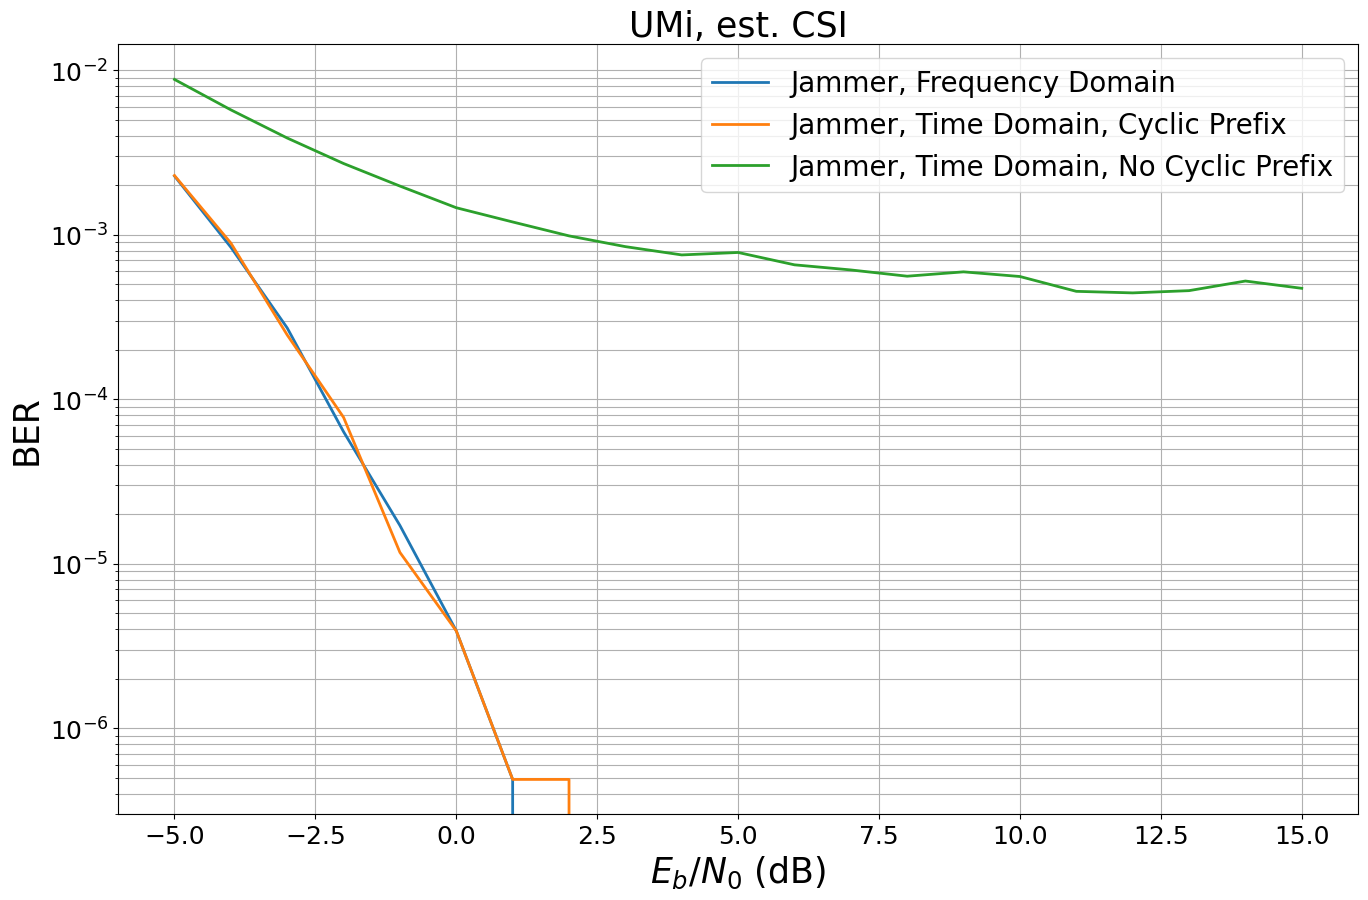

In [4]:
ber_plots.reset()
model_parameters = {}
jammer_parameters = {}
model_parameters["jammer_parameters"] = jammer_parameters
model_parameters["num_ut"] = 4
model_parameters["perfect_csi"] = True
model_parameters["perfect_jammer_csi"] = True
model_parameters["num_silent_pilot_symbols"] = 0
model_parameters["jammer_present"] = True
model_parameters["jammer_power"] = db_to_linear(25.)
model_parameters["jammer_mitigation"] = "ian"
model_parameters["scenario"] = "multitap_rayleigh"
# model_parameters["jammer_mitigation_dimensionality"] = 3
sim.BATCH_SIZE = 4
sim.MAX_MC_ITER = 50
# sim.ebno_dbs = np.linspace(-5., 15., 10)
sim.ebno_dbs = np.linspace(-5., 15., 21)

model = Model(**model_parameters)
simulate_model(model, "Jammer, Frequency Domain")

model_parameters["domain"] = "time"
jammer_parameters["send_cyclic_prefix"] = True
model = Model(**model_parameters)
simulate_model(model, "Jammer, Time Domain, Cyclic Prefix")

jammer_parameters["send_cyclic_prefix"] = False
model = Model(**model_parameters)
simulate_model(model, "Jammer, Time Domain, No Cyclic Prefix")

ber_plots.title = "Multitap-Rayleigh, est. CSI"
ber_plots()
with open("bers/time_pos.pickle", 'rb') as f:
    bers = pickle.dump(ber_plots, f)